In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
!pip install apyori
import pandas as pd
import matplotlib.pyplot as plt
from apyori import apriori

In [29]:
# a)
# read csv file
df = pd.read_csv('/content/drive/My Drive/music.csv')
df

,customer,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany
...,...,...,...,...
289950,19718,bob dylan,f,Canada
289951,19718,pixies,f,Canada
289952,19718,the clash,f,Canada
289953,19718,a tribe called quest,f,Canada


In [30]:
# make sure that all variables (columns) are factors
df = df.astype('category')

# display the top 19 rows in the dataframe
df.head(19)

,customer,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany
5,1,schandmaul,f,Germany
6,1,edguy,f,Germany
7,1,jack johnson,f,Germany
8,1,eluveitie,f,Germany
9,1,the killers,f,Germany


In [31]:
# remove gender and country variables
df = df.drop(columns=['sex', 'country'])

In [32]:
unknown = df[df['artist'] == '[unknown]'].shape[0]
print(f"There are {unknown} songs from unknown artists in the dataset")

There are 553 songs from unknown artists in the dataset


In [33]:
# remove all rows with unknown artists name from df
df = df[df['artist'] != '[unknown]']
df.shape
# df.head(19)

(289402, 2)

In [34]:
# b)
# group songs by customer and convert each group into a list
playlist = df.groupby('customer')['artist'].apply(list)

# create an empty list to store the list of songs without duplicates
distinct_playlist = []
# for each customer's list of songs, remove duplicates and add to the new list
for songs in playlist:
    unique_songs = list(set(songs))
    distinct_playlist.append(unique_songs)

#distinct_playlist

In [35]:
# see first user’s songs
print(distinct_playlist[0])
length0 = len(distinct_playlist[0])

['goldfrapp', 'the black dahlia murder', 'eluveitie', 'the killers', 'the who', 'guano apes', 'john mayer', 'le tigre', 'the rolling stones', 'jack johnson', 'schandmaul', 'red hot chili peppers', 'rob zombie', 'dropkick murphys', 'judas priest', 'edguy']


In [36]:
print(f"There are {length0} artists in the first transaction")

There are 16 artists in the first transaction


In [37]:
# see first two users’ songs
print(distinct_playlist[:2])
length1 = len(distinct_playlist[1])

[['goldfrapp', 'the black dahlia murder', 'eluveitie', 'the killers', 'the who', 'guano apes', 'john mayer', 'le tigre', 'the rolling stones', 'jack johnson', 'schandmaul', 'red hot chili peppers', 'rob zombie', 'dropkick murphys', 'judas priest', 'edguy'], ['broken social scene', 'the flashbulb', 'boards of canada', 'autechre', 'neutral milk hotel', 'cocorosie', 'the books', 'radiohead', 'aphex twin', 'm83', 'pavement', 'animal collective', 'max richter', 'massive attack', 'mf doom', 'four tet', 'joanna newsom', 'aesop rock', 'goldfrapp', 'plaid', 'devendra banhart', 'air', 'portishead', 'prefuse 73', 'beastie boys', 'atmosphere', 'arcade fire', 'amon tobin', 'sage francis']]


In [38]:
print(f"There are {length1} artists in the second transaction")

There are 29 artists in the second transaction


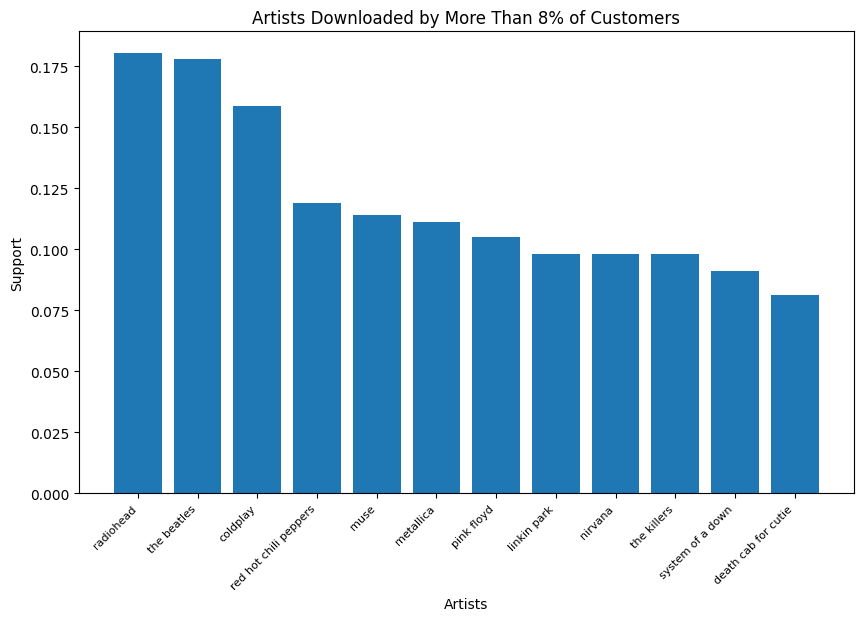

In [39]:
# c)
results = list(apriori(distinct_playlist, min_support=0.08))

itemsets = []
supports = []

for result in results:
    itemsets.append(', '.join(result.items))
    supports.append(result.support)


frequent_itemsets_df = pd.DataFrame({'itemsets': itemsets, 'support': supports})
frequent_itemsets_sorted = frequent_itemsets_df.sort_values(by='support', ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(frequent_itemsets_sorted['itemsets'], frequent_itemsets_sorted['support'])
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel('Support')
plt.xlabel('Artists')
plt.title('Artists Downloaded by More Than 8% of Customers')
plt.show()

In [40]:
most_popular_artist = frequent_itemsets_sorted.iloc[0]['itemsets']
print(f"The most popular artist is: {most_popular_artist}")

The most popular artist is: radiohead


In [41]:
# d)
results2 = list(apriori(distinct_playlist, min_support=0.01, min_confidence=0.5))


rules = []
for result in results2:
    for rule in result.ordered_statistics:
        if rule.items_base and rule.items_add:
            rules.append({
                'antecedents': rule.items_base,
                'consequents': rule.items_add,
                'confidence': rule.confidence,
                'lift': rule.lift,
                'support': result.support
            })


rules_df = pd.DataFrame(rules)

# sort the rules by lift
rules_sorted = rules_df.sort_values(by="lift", ascending=False)

def check_artists(antecedents):
    return 'the beatles' in antecedents and 'the smashing pumpkins' in antecedents

filtered_rules = rules_sorted[rules_sorted['antecedents'].apply(check_artists)]
filtered_rules

,antecedents,consequents,confidence,lift,support
48,"(the beatles, the smashing pumpkins)",(radiohead),0.620939,3.444556,0.011467


In [42]:
# I would suggest radiohead to a customer who listened to the beattles and the smashing punmpkins.

In [43]:
# e)
results3 = list(apriori(distinct_playlist, min_support=0.01, min_confidence=0.5, min_lift = 5))

rules = []
for result in results3:
    for rule in result.ordered_statistics:
        if rule.items_base and rule.items_add:
            rules.append({
                'antecedents': rule.items_base,
                'consequents': rule.items_add,
                'confidence': rule.confidence,
                'lift': rule.lift,
                'support': result.support
            })


rules_df3 = pd.DataFrame(rules)

# sort the rules by lift
rules_sorted3 = rules_df3.sort_values(by="confidence", ascending=False)

def check_artists3(antecedents):
    return 'judas priest' in antecedents

suggest_rule = rules_sorted3[rules_sorted3['antecedents'].apply(check_artists3)]
suggest_rule

,antecedents,consequents,confidence,lift,support
0,(judas priest),(iron maiden),0.5075,8.562992,0.013533


In [44]:
# I would suggest iron maiden to a customer who listened to judas priest.